# Stock Market Prediction

## Overview

The goal of this project

## Business Understanding

The prediction problem of stock market

## Data Understanding

Data Collection by API

### Import Packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
import time
import itertools
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import pickle

# import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('darkgrid')
#import geopandas as gpd
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import register_matplotlib_converters
# display preferences
register_matplotlib_converters()

### Coronavirus API

https://iexcloud.io

In [23]:
#url ='https://cloud.iexapis.com/stable/stock/{}/chart/5y?token={}'.format(symbol, token)
url = 'https://cloud.iexapis.com/stock/aapl/batch'

random = np.random.uniform(0, 1, 501)
# time.sleep(random[i])
params = {  
            #'source': 'csbs',
            #'country_code': 'US',           
            #'timelines': 1
          }

response = requests.get(url, params)
d = response.json()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [12]:
d['']

[{'url': 'http://api.iextrading.com/1.0',
  'variables': {'protocol': {'default': 'https', 'enum': ['https']}}}]

In [26]:
import yfinance as yf

In [27]:
tickers = yf.Tickers('msft aapl goog')
# ^ returns a named tuple of Ticker objects

# access each ticker using (example)
tickers.tickers.MSFT.info
tickers.tickers.AAPL.history(period="1mo")
tickers.tickers.GOOG.actions

,Dividends,Stock Splits
Date,,
2014-03-27,0.0,2.002000
2015-04-27,0.0,1.002746


In [31]:
msft = yf.Ticker("MSFT")
msft.dividends

Date
2003-02-19    0.08
2003-10-15    0.16
2004-08-23    0.08
2004-11-15    3.08
2005-02-15    0.08
              ... 
2019-11-20    0.51
2020-02-19    0.51
2020-05-20    0.51
2020-08-19    0.51
2020-11-18    0.56
Name: Dividends, Length: 68, dtype: float64

In [32]:
msft.options

('2021-02-12',
 '2021-02-19',
 '2021-02-26',
 '2021-03-05',
 '2021-03-12',
 '2021-03-19',
 '2021-03-26',
 '2021-04-16',
 '2021-06-18',
 '2021-07-16',
 '2021-09-17',
 '2022-01-21',
 '2022-03-18',
 '2022-06-17',
 '2022-09-16',
 '2023-01-20',
 '2023-03-17')

In [74]:
df = yf.download("AAPL", start="2017-01-01", end="2021-02-01")

[*********************100%***********************]  1 of 1 completed


In [77]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.459938,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.429203,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.568691,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.876030,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,28.131361,134247600
...,...,...,...,...,...,...
2021-01-25,143.070007,145.089996,136.539993,142.919998,142.706757,157611700
2021-01-26,143.600006,144.300003,141.369995,143.160004,142.946396,98390600
2021-01-27,143.429993,144.300003,140.410004,142.059998,141.848038,140843800


In [47]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [79]:
df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-17',
               ...
               '2021-01-15', '2021-01-19', '2021-01-20', '2021-01-21',
               '2021-01-22', '2021-01-25', '2021-01-26', '2021-01-27',
               '2021-01-28', '2021-01-29'],
              dtype='datetime64[ns]', name='Date', length=1026, freq=None)

## Data Preparation

### Exploratory Data Analysis

Text(0.5, 1.0, 'close')

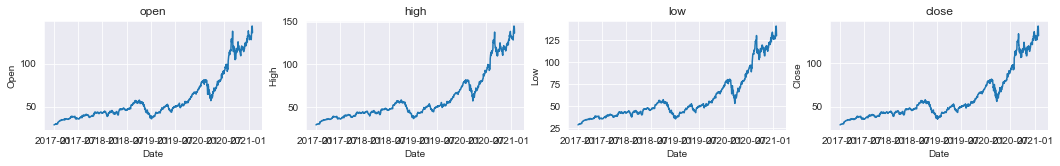

In [51]:
# plot target variables
fig, ax = plt.subplots(1, 4, figsize=(18,2))
sns.lineplot(data=df.Open, ax=ax[0])
ax[0].set_title('open')
sns.lineplot(data=df.High, ax=ax[1])
ax[1].set_title('high')
sns.lineplot(data=df.Low, ax=ax[2])
ax[2].set_title('low')
sns.lineplot(data=df.Close, ax=ax[3])
ax[3].set_title('close')
# plt.subplots_adjust(hspace = 0.5)

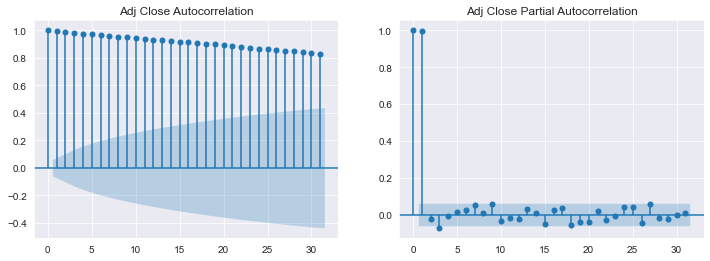

In [56]:
# Plot deaths ACF & PACF
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(df['Adj Close'], title='Adj Close Autocorrelation', ax=ax[0]);
plot_pacf(df['Adj Close'], title='Adj Close Partial Autocorrelation', ax=ax[1]);
#plt.savefig('images/acf.jpeg', format='jpeg')

### Dickey-Fuller Test

In [57]:
def stationarity_check(TS):       
    # Perform the Dickey Fuller test
    dftest = adfuller(TS)     
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=7, center=False).mean()
    roll_std = TS.rolling(window=7, center=False).std()    
    # Plot rolling statistics:
    #fig = plt.figure(figsize=(12,6))
    orig = sns.lineplot(data=TS, palette=['blue'],label='Original')
    mean = sns.lineplot(data=roll_mean, palette=['red'], label='Rolling Mean')
    std = sns.lineplot(data=roll_std, palette=['black'], label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])                   
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

,Adj Close
Date,
2017-01-03,27.459938
2017-01-04,27.429203
2017-01-05,27.568691
2017-01-06,27.876030
2017-01-09,28.131361
...,...
2021-01-25,142.706757
2021-01-26,142.946396
2021-01-27,141.848038


In [76]:
df.reset_index('close')

KeyError: 'Requested level (close) does not match index name (Date)'

In [82]:
a = np.arange(10)
a = pd.DataFrame(a)
a

,0
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [85]:
seasonal_decompose(a,freq='D')

TypeError: '<' not supported between instances of 'int' and 'str'

In [84]:
# Apply seasonal_decompose()
decomposition = seasonal_decompose(df.close, freq='D')
# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

AttributeError: 'DataFrame' object has no attribute 'close'

NameError: name 'trend' is not defined

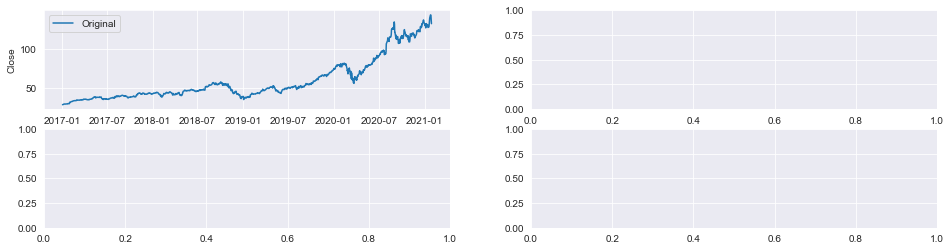

In [86]:
# Plot gathered statistics
fig, ax = plt.subplots(2, 2, figsize=(16,4))
sns.lineplot(data=df.Close, label='Original', ax=ax[0][0])
sns.lineplot(data=trend, label='Trend', ax=ax[0][1])
sns.lineplot(data=seasonal,label='Seasonality', ax=ax[1][0])
sns.lineplot(data=residual, label='Residuals', ax=ax[1][1])
plt.tight_layout()

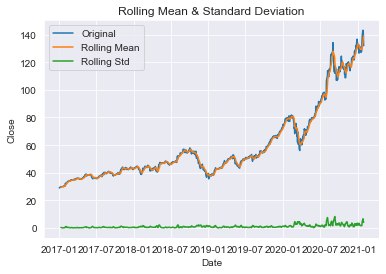

Results of Dickey-Fuller Test: 

Test Statistic                    0.977604
p-value                           0.994024
#Lags Used                       22.000000
Number of Observations Used    1003.000000
Critical Value (1%)              -3.436887
Critical Value (5%)              -2.864426
Critical Value (10%)             -2.568307
dtype: float64


In [87]:
stationarity_check(df.Close)

## Modeling

### ARIMA

In [90]:
# construct seperate dataframes per target variable
close = pd.DataFrame(df.Close, index=df.index)



ARIMA_MODEL = SARIMAX(endog=df.Close,
                      order=(2,1,2),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()
print(output.summary().tables[0])
print(output.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1026
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1838.501
Date:                Mon, 08 Feb 2021   AIC                           3687.003
Time:                        15:29:19   BIC                           3711.650
Sample:                             0   HQIC                          3696.361
                               - 1026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8530      0.009   -206.062      0.000      -1.871      -1.835
ar.L2         -0.9741      0.009   -109.239      0.000      -0.992      -0.957
ma.L1          1.8300      0.013    135.584      0.0

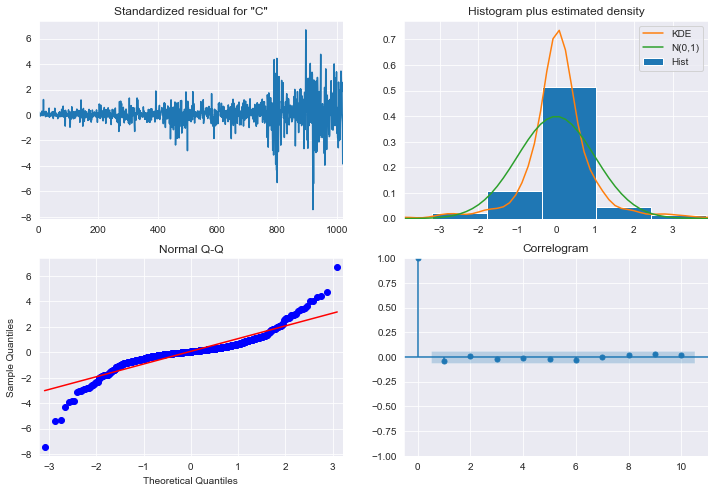

In [91]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(12, 8))
plt.show()

In [92]:
# Get predictions starting from past 60 days and calculate confidence intervals
pred = output.get_prediction(start=close.index[-100], end=close.index[-1], dynamic=False)
pred_conf = pred.conf_int()

In [93]:
# Get the real and predicted values
close_forecasted = pred.predicted_mean
close_truth = close[-100:]
# calculate mean absolute error
arima_mae = mean_absolute_error(close_forecasted, close_truth)
# Compute the root mean square error
arima_rmse = mean_squared_error(close_forecasted, close_truth, squared=False)

In [94]:
arima_mae,arima_rmse

(2.196069436035352, 2.76977423777968)

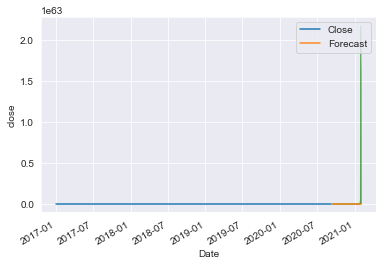

In [101]:
# Plot real vs predicted values along with confidence interval
#plt.rcParams['figure.figsize'] = 12, 2
# Plot observed values
ax = close[:-100].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                np.exp(pred_conf).iloc[:, 0],
                np.exp(pred_conf).iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('close')
plt.legend()

plt.show()

In [102]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=close.index[-100], end=close.index[-1], dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int(alpha=0.1)

In [104]:
# Get the real and dynamic predicted values
deaths_forecasted = pred_dynamic.predicted_mean
deaths_truth = close[-100:]

# calculate mean absolute error
arima_dynamic_mae = mean_absolute_error(close_forecasted, close_truth)
# Compute the root mean square error
arima_dynamic_rmse = mean_squared_error(close_forecasted, close_truth, squared=False)

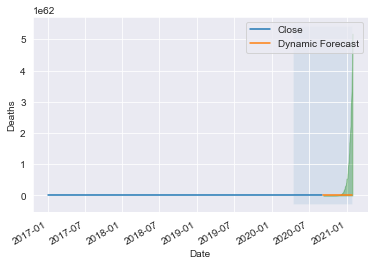

In [105]:
# Plot the dynamic forecast with confidence intervals.

ax = close[:-len(close)//10].plot(label='observed')
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                np.exp(pred_dynamic_conf.iloc[:, 0]),
                np.exp(pred_dynamic_conf.iloc[:, 1]), color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), close[:-len(close)//10].index[-100], close_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Deaths')

plt.legend()
plt.show()

In [573]:
# Re-run model on entire dataset
ARIMA_MODEL = SARIMAX(endog=np.log(deaths),
                      order=(2,1,2),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()
                      
print(output.summary().tables[0])
print(output.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:          deathIncrease   No. Observations:                  384
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -175.701
Date:                Mon, 01 Feb 2021   AIC                            361.403
Time:                        10:59:35   BIC                            381.104
Sample:                    01-13-2020   HQIC                           369.220
                         - 01-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7395      0.195      3.787      0.000       0.357       1.122
ar.L2         -0.4350      0.139     -3.138      0.002      -0.707      -0.163
ma.L1         -2.7177    625.946     -0.004      0.9

In [574]:
# Get forecast 30 days ahead in future
prediction = output.get_forecast(steps=len(deaths)//10+30)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int(alpha=.1)

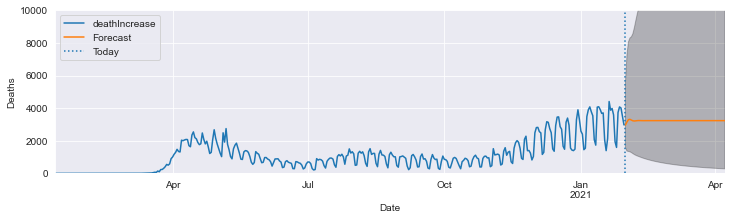

In [548]:
# Plot future predictions with confidence intervals
ax = deaths.plot(label='observed', figsize=(12, 3), )
np.exp(prediction.predicted_mean).plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                np.exp(pred_conf.iloc[:, 0]),
                np.exp(pred_conf.iloc[:, 1]), color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
plt.ylim(bottom=0, top=10000)
plt.vlines(x=deaths.index[-1]+pd.DateOffset(1), ymin=0, ymax=10000, linestyles='dotted', label='Today')
plt.legend(loc='upper left')
plt.show()

### SARIMAX

In [549]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0, 1)
d = range(1, 2)
q = range(1, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

p = range(0, 2)
d = range(0, 2)
q = range(0, 3)

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [25]:
"""UNCOMMENT THIS CELL TO RUN GRID SEARCH"""
# # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
# ans = []
# for comb in pdq:
#     for combs in pdqs:
#         try:
#             mod = SARIMAX(deaths,
#                             order=comb,
#                             seasonal_order=combs,
#                             enforce_stationarity=False,
#                             enforce_invertibility=False)

#             output = mod.fit()
#             ans.append([comb, combs, output.aic])
#             print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
#         except:
#             continue

# # Find the parameters with minimal AIC value
# ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

# # pickle grid parameters
# pickle_out = open("death_grid.pickle","wb")
# pickle.dump(ans_df, pickle_out)
# pickle_out.close()

'UNCOMMENT THIS CELL TO RUN GRID SEARCH'

In [550]:
# load grid parameters
ans_df = pd.read_pickle('death_grid.pickle')

In [551]:
# Check grid search results
ans_df.loc[ans_df['aic'].idxmin()][0], ans_df.loc[ans_df['aic'].idxmin()][1]

((0, 1, 1), (0, 1, 2, 7))

In [584]:
# Run model on training dataset only (first 90% of dates)
SARIMAX_MODEL = SARIMAX(endog=np.log(deaths[:-len(deaths)//10]),
                      order=ans_df.loc[ans_df['aic'].idxmin()][0],
                      seasonal_order=ans_df.loc[ans_df['aic'].idxmin()][1],
                      enforce_stationarity=False,
                      enforce_invertibility=False)

# Fit the model and print results
output = SARIMAX_MODEL.fit()

print(output.summary().tables[0])
print(output.summary().tables[1])

                                       SARIMAX Results                                        
Dep. Variable:                          deathIncrease   No. Observations:                  345
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 7)   Log Likelihood                 -26.983
Date:                                Mon, 01 Feb 2021   AIC                             61.966
Time:                                        11:26:34   BIC                             77.051
Sample:                                    01-13-2020   HQIC                            67.989
                                         - 12-22-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4448      0.036    -12.498      0.000      -0.515      -0.375
ma.

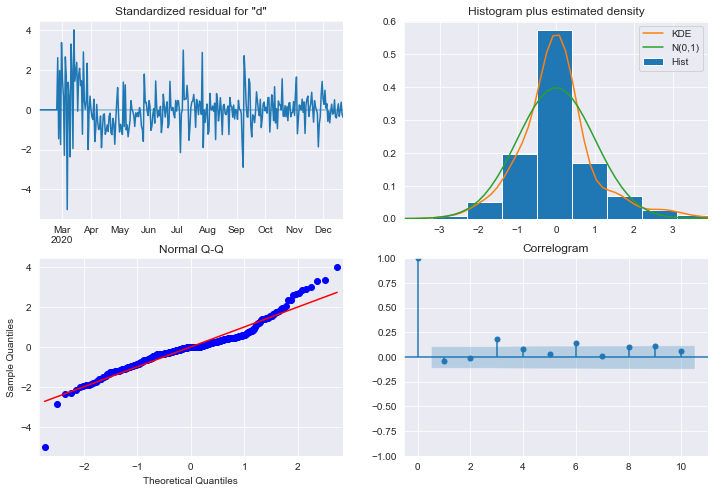

In [553]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(12, 8))
plt.show()

In [585]:
# Get predictions for training set and calculate confidence intervals
pred = output.get_prediction(start=deaths[:-len(deaths)//10].index[-100], end=deaths[:-len(deaths)//10].index[-1], dynamic=False)
pred_conf = pred.conf_int()

In [586]:
# Get the real and predicted values
deaths_forecasted = np.exp(pred.predicted_mean)
deaths_truth = deaths[-100:]

# calculate mean absolute error
sarimax_mae = mean_absolute_error(deaths_forecasted, deaths_truth.deathIncrease)
# Compute the root mean square error
sarimax_rmse = mean_squared_error(deaths_forecasted, deaths_truth.deathIncrease, squared=False)

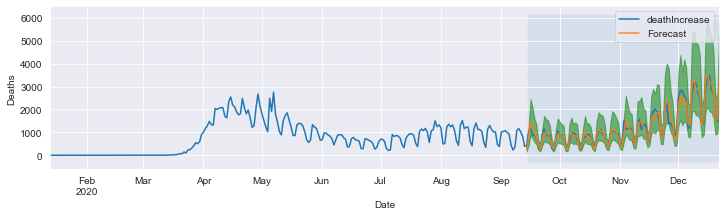

In [556]:
# Plot real vs predicted values along with confidence interval

plt.rcParams['figure.figsize'] = 12, 3

# Plot observed values
ax = deaths[:-len(deaths)//10].plot(label='observed')

# Plot predicted values
np.exp(pred.predicted_mean).plot(ax=ax, label='Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                np.exp(pred_conf).iloc[:, 0],
                np.exp(pred_conf).iloc[:, 1], color='g', alpha=0.5)

ax.fill_betweenx(ax.get_ylim(), deaths[:-len(deaths)//10].index[-100], deaths_forecasted.index[-1], alpha=.1, zorder=-1)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
plt.legend()
plt.show()

In [587]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=deaths[:-len(deaths)//10].index[-100], end=deaths[:-len(deaths)//10].index[-1], dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int(alpha=0.1)

In [588]:
# Get the real and dynamic predicted values
deaths_forecasted = np.exp(pred_dynamic.predicted_mean)
deaths_truth = deaths[-100:]

# calculate mean absolute error
sarimax_dynamic_mae = mean_absolute_error(deaths_forecasted, deaths_truth.deathIncrease)
# Compute the root mean square error
sarimax_dynamic_rmse = mean_squared_error(deaths_forecasted, deaths_truth.deathIncrease, squared=False)

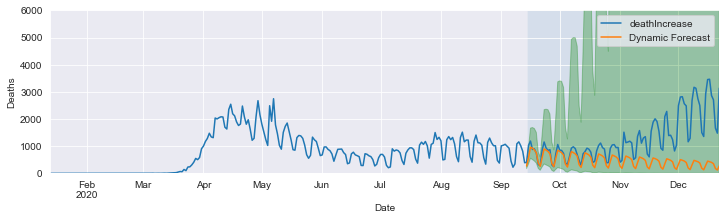

In [559]:
# Plot the dynamic forecast with confidence intervals.

ax = deaths[:-len(deaths)//10].plot(label='observed', figsize=(12, 3))
np.exp(pred_dynamic.predicted_mean).plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                np.exp(pred_dynamic_conf.iloc[:, 0]),
                np.exp(pred_dynamic_conf.iloc[:, 1]), color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), deaths[:-len(deaths)//10].index[-100], deaths_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
ax.set_ylim(bottom=0, top=6000)

plt.legend()
plt.show()

In [560]:
# Re-run model on entire dataset
SARIMAX_MODEL = SARIMAX(endog=np.log(deaths),
                      order=ans_df.loc[ans_df['aic'].idxmin()][0],
                      seasonal_order=ans_df.loc[ans_df['aic'].idxmin()][1],
                      enforce_stationarity=False,
                      enforce_invertibility=False)

# Fit the model and print results
output = SARIMAX_MODEL.fit()

print(output.summary().tables[0])
print(output.summary().tables[1])

                                       SARIMAX Results                                        
Dep. Variable:                          deathIncrease   No. Observations:                  384
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 7)   Log Likelihood                 -22.631
Date:                                Mon, 01 Feb 2021   AIC                             53.261
Time:                                        10:39:29   BIC                             68.806
Sample:                                    01-13-2020   HQIC                            59.442
                                         - 01-30-2021                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4372      0.033    -13.118      0.000      -0.502      -0.372
ma.

In [561]:
# Get forecast 30 days ahead in future
prediction = output.get_forecast(steps=len(deaths)//10+30)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int(alpha=.1)

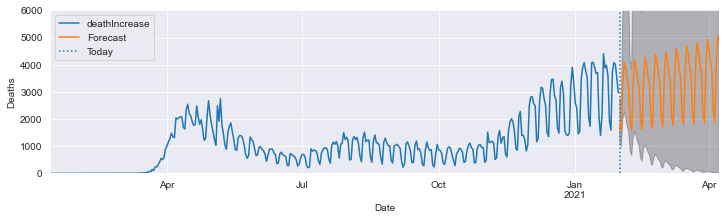

In [562]:
# Plot future predictions with confidence intervals
ax = deaths.plot(label='observed', figsize=(12, 3))
np.exp(prediction.predicted_mean).plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                np.exp(pred_conf.iloc[:, 0]),
                np.exp(pred_conf.iloc[:, 1]), color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
ax.set_ylim(bottom=0, top=6000)
plt.vlines(x=deaths.index[-1]+pd.DateOffset(1), ymin=0, ymax=10000, linestyles='dotted', label='Today')
plt.legend()
plt.show()

## Facebook Prophet

In [240]:
# ts.index.name = 'ds'
# ts = ts.reset_index()
# ts = ts.rename(columns={'timeline': 'y'})

In [119]:
fb_close = pd.DataFrame()
fb_close['y'] = df.Close
fb_close.reset_index(inplace=True)
fb_close.rename(columns={'Date': 'ds'}, inplace=True)

In [120]:
close_train_fb, close_test_fb = fb_close[:-100], fb_close[-100:]

In [121]:
model_close = Prophet(interval_width=0.95)
model_close.fit(close_train_fb)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [123]:
future_dates = model_close.make_future_dataframe(periods=100, freq='D')
forecast_close = model_close.predict(future_dates)
forecast_close.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-03,22.694997,23.086766,33.311547,22.694997,22.694997,5.671616,5.671616,5.671616,-1.119704,-1.119704,-1.119704,6.791319,6.791319,6.791319,0.0,0.0,0.0,28.366612
1,2017-01-04,22.990166,23.829725,34.239503,22.990166,22.990166,5.744666,5.744666,5.744666,-0.996940,-0.996940,-0.996940,6.741606,6.741606,6.741606,0.0,0.0,0.0,28.734832
2,2017-01-05,23.285335,23.708962,34.008442,23.285335,23.285335,5.547539,5.547539,5.547539,-1.141924,-1.141924,-1.141924,6.689462,6.689462,6.689462,0.0,0.0,0.0,28.832874
3,2017-01-06,23.580504,24.013964,34.006643,23.580504,23.580504,5.457804,5.457804,5.457804,-1.176416,-1.176416,-1.176416,6.634220,6.634220,6.634220,0.0,0.0,0.0,29.038308
4,2017-01-09,24.466012,24.591822,34.972447,24.466012,24.466012,5.236852,5.236852,5.236852,-1.205301,-1.205301,-1.205301,6.442153,6.442153,6.442153,0.0,0.0,0.0,29.702864


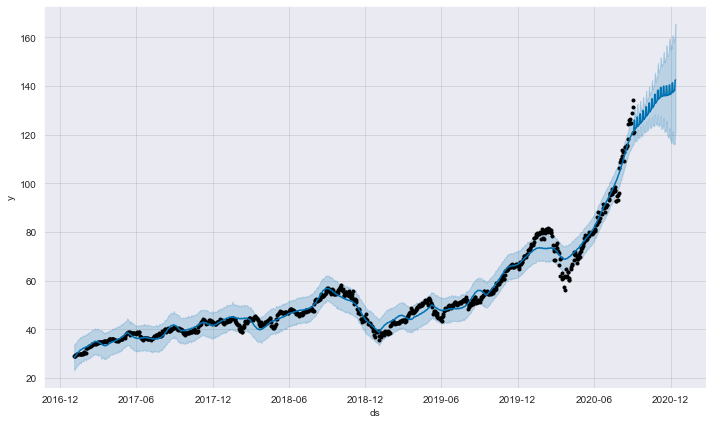

In [124]:
model_close.plot(forecast_close, uncertainty=True);

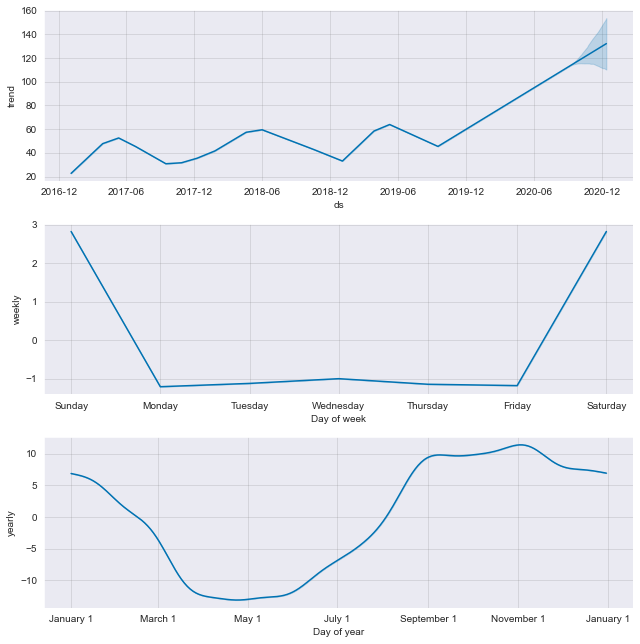

In [125]:
model_close.plot_components(forecast_close);

## LSTM (long short-term memory) Networks

In [126]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [127]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [129]:
df_lstm = pd.DataFrame()
df_lstm['close'] = df.Close

In [130]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_lstm)

In [131]:
train, test = dataset[:-100], dataset[-100:]

In [132]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [133]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [134]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [135]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

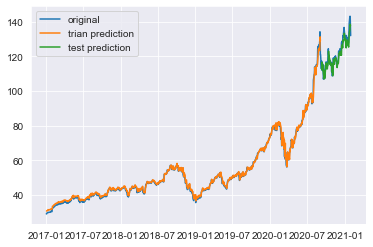

In [136]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(df_lstm.index, scaler.inverse_transform(dataset), label='original')
plt.plot(df_lstm.index, trainPredictPlot,label='trian prediction')
plt.plot(df_lstm.index, testPredictPlot,label='test prediction')
plt.legend()
#plt.savefig('images/lstm.jpeg', format='jpeg')

## Evaluation

### metrics in ARIMA

In [583]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(arima_rmse, 2)))
print('The Mean Absolute Error of our forecasts is {}'.format(round(arima_mae, 2)))
print('The Root Mean Squared Error of our dynamic forecasts is {}'.format(round(arima_dynamic_rmse, 2)))
print('The Mean Absolute Error of our dynamic forecasts is {}'.format(round(arima_dynamic_mae, 2)))

The Root Mean Squared Error of our forecasts is 1408.59
The Mean Absolute Error of our forecasts is 1166.59
The Root Mean Squared Error of our dynamic forecasts is 1921.32
The Mean Absolute Error of our dynamic forecasts is 1572.88


### metrics in SARIMAX

In [589]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(sarimax_rmse, 2)))
print('The Mean Absolute Error of our forecasts is {}'.format(round(sarimax_mae, 2)))
print('The Root Mean Squared Error of our dynamic forecasts is {}'.format(round(sarimax_dynamic_rmse, 2)))
print('The Mean Absolute Error of our dynamic forecasts is {}'.format(round(sarimax_dynamic_mae, 2)))

The Root Mean Squared Error of our forecasts is 1456.22
The Mean Absolute Error of our forecasts is 1172.59
The Root Mean Squared Error of our dynamic forecasts is 2102.79
The Mean Absolute Error of our dynamic forecasts is 1731.63


### metrics in Facebook Prophet

In [305]:
# calculate root mean squared error
train_rmse_death_fb = mean_squared_error(death_train_fb['y'], forecast_death['yhat'][:-100], squared=False)
test_rmse_death_fb = mean_squared_error(death_test_fb['y'], forecast_death['yhat'][-100:], squared=False)
print('Facebook Prophet deathIncrease train RMSE: {:.2f}'.format(train_rmse_death_fb))
print('Facebook Prophet deathIncrease test RMSE: {:.2f}'.format(test_rmse_death_fb))
# calculate mean absolute error
train_mae_death_fb = mean_absolute_error(death_train_fb['y'], forecast_death['yhat'][:-100])
test_mae_death_fb = mean_absolute_error(death_test_fb['y'], forecast_death['yhat'][-100:])
print('Facebook Prophet deathIncrease train MAE: {:.2f}'.format(train_mae_death_fb))
print('Facebook Prophet deathIncrease test MAE: {:.2f}'.format(test_mae_death_fb))

Facebook Prophet deathIncrease train RMSE: 432.03
Facebook Prophet deathIncrease test RMSE: 1929.95
Facebook Prophet deathIncrease train MAE: 321.32
Facebook Prophet deathIncrease test MAE: 1579.82


In [469]:
# calculate root mean squared error
train_rmse_mortality_fb = mean_squared_error(mortality_train_fb['y'], forecast_mortality['yhat'][:-100], squared=False)
test_rmse_mortality_fb = mean_squared_error(mortality_test_fb['y'], forecast_mortality['yhat'][-100:], squared=False)
print('Facebook Prophet mortality train RMSE: {:.4f}'.format(train_rmse_mortality_fb))
print('Facebook Prophet mortality test RMSE: {:.4f}'.format(test_rmse_mortality_fb))
# calculate mean absolute error
train_mae_mortality_fb = mean_absolute_error(mortality_train_fb['y'], forecast_mortality['yhat'][:-100])
test_mae_mortality_fb = mean_absolute_error(mortality_test_fb['y'], forecast_mortality['yhat'][-100:])
print('Facebook Prophet mortality train MAE: {:.4f}'.format(train_mae_mortality_fb))
print('Facebook Prophet mortality test MAE: {:.4f}'.format(test_mae_mortality_fb))

Facebook Prophet mortality train RMSE: 0.0848
Facebook Prophet mortality test RMSE: 0.0173
Facebook Prophet mortality train MAE: 0.0277
Facebook Prophet mortality test MAE: 0.0150


### metrics in LSTM Networks

In [343]:
# calculate root mean squared error
trainScore = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
testScore = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('LSTM Networks deathIncrease train RMSE: {:.2f}'.format(trainScore))
print('LSTM Networks deathIncrease test RMSE: {:.2f}'.format(testScore))
# calculate mean absolute error
trainScore_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
testScore_mae = mean_absolute_error(testY[0], testPredict[:,0])
print('LSTM Networks deathIncrease train MAE: {:.2f}'.format(trainScore_mae))
print('LSTM Networks deathIncrease test MAE: {:.2f}'.format(testScore_mae))

LSTM Networks deathIncrease train RMSE: 275.27
LSTM Networks deathIncrease test RMSE: 788.28
LSTM Networks deathIncrease train MAE: 183.45
LSTM Networks deathIncrease test MAE: 563.24


## Conclusion

1. LSTM Networks serve as the best model for coronavirus prediction with small RMSE and MAE.
2. SARIMAX with opitmized hyperparameters by Gridsearch also work well for the prediction.
3. Due to limited known condtions, it is difficult to make precise predictions.
4. It shows less death and positive cases at weekends and more cases on Monday.